In [1]:
import glob

import geopandas as gpd
import matplotlib
%matplotlib inline
import pandas as pd

In [2]:
days = sorted([d for d in glob.glob("data/*") if 'tar' not in d])
days

['data/2019-02-28',
 'data/2019-03-01',
 'data/2019-03-02',
 'data/2019-03-03',
 'data/2019-03-04',
 'data/2019-04-01',
 'data/gtfs']

In [3]:
d0 = days[-2]
import json

def process_json(fname):
    with open(fname) as f:
        data = json.load(f)
        if set(data.keys()) != set(['BusPositions']):
            raise Exception("Other keys? {}".format(set(data.keys())))
        return data['BusPositions']
df = pd.concat((pd.DataFrame(process_json(x)) for x in  glob.glob(d0+"/*")), ignore_index=True)

In [4]:
df.head()

,BlockNumber,DateTime,Deviation,DirectionNum,DirectionText,Lat,Lon,RouteID,TripEndTime,TripHeadsign,TripID,TripStartTime,VehicleID
0,NH-81,2019-04-01T13:30:26,-1.0,0,EAST,38.937237,-77.023651,H8,2019-04-01T09:43:00,RHODE ISLAND AVE STATION,940419020,2019-04-01T09:06:00,7215
1,SW-25,2019-04-01T13:30:31,2.0,0,EAST,38.862076,-76.994499,W3,2019-04-01T10:28:00,UNITED MEDICAL CENTER,912221020,2019-04-01T09:28:00,3047
2,N-603,2019-04-01T13:30:24,4.0,0,NORTH,38.941589,-77.025345,60,2019-04-01T11:17:00,FORT TOTTEN,918960020,2019-04-01T11:00:00,7359
3,B-330,2019-04-01T13:30:32,-9.0,0,EAST,38.884029,-76.994301,34,2019-04-01T11:48:00,NAYLOR RD STATION,940949020,2019-04-01T11:10:00,2884
4,MY-16,2019-04-01T13:30:37,0.0,1,SOUTH,38.993397,-77.028229,Y8,2019-04-01T13:00:00,SILVER SPRING STATION,925465020,2019-04-01T11:49:00,7365


In [6]:
garr = gpd.vectorized.points_from_xy(df["Lon"].as_matrix(), df["Lat"].as_matrix())

In [7]:
df["geometry"] = garr
gdf = gpd.GeoDataFrame(df)
gdf.crs = {'init' :'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

I am densified (external_values, 655304 elements)


In [8]:
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

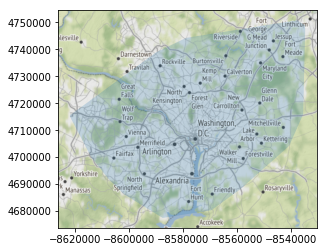

In [9]:
ax = gpd.GeoSeries([gdf.geometry.unary_union.convex_hull]).plot(alpha=.2)
add_basemap(ax, 10)

In [10]:
gdf["dt"] = pd.to_datetime(gdf["DateTime"])
gdf = gdf.sort_values("dt")
gdf.head()

I am densified (5 elements)
I am densified (5 elements)


,BlockNumber,DateTime,Deviation,DirectionNum,DirectionText,Lat,Lon,RouteID,TripEndTime,TripHeadsign,TripID,TripStartTime,VehicleID,geometry,dt
379811,SW-21,2019-03-31T19:46:15,-4.0,0,EAST,38.85984,-76.996033,W2,2019-03-31T20:35:00,UNITED MEDICAL CENTER,912392010,2019-03-31T19:45:00,3059,POINT (-8571159.186662087 4701614.694362001),2019-03-31 19:46:15
23761,SW-21,2019-03-31T19:46:15,-4.0,0,EAST,38.85984,-76.996033,W2,2019-03-31T20:35:00,UNITED MEDICAL CENTER,912392010,2019-03-31T19:45:00,3059,POINT (-8571159.186662087 4701614.694362001),2019-03-31 19:46:15
29039,SW-21,2019-03-31T19:46:15,-4.0,0,EAST,38.85984,-76.996033,W2,2019-03-31T20:35:00,UNITED MEDICAL CENTER,912392010,2019-03-31T19:45:00,3059,POINT (-8571159.186662087 4701614.694362001),2019-03-31 19:46:15
594012,SW-21,2019-03-31T19:46:15,-4.0,0,EAST,38.85984,-76.996033,W2,2019-03-31T20:35:00,UNITED MEDICAL CENTER,912392010,2019-03-31T19:45:00,3059,POINT (-8571159.186662087 4701614.694362001),2019-03-31 19:46:15
369234,SW-21,2019-03-31T19:46:15,-4.0,0,EAST,38.85984,-76.996033,W2,2019-03-31T20:35:00,UNITED MEDICAL CENTER,912392010,2019-03-31T19:45:00,3059,POINT (-8571159.186662087 4701614.694362001),2019-03-31 19:46:15


### Filter to 1 line only (S4)

In [11]:
s4_only = gdf[gdf["RouteID"] == "S4"]
len(s4_only), s4_only.TripID.nunique()

(6120, 107)

### Look at distribution of # of reports

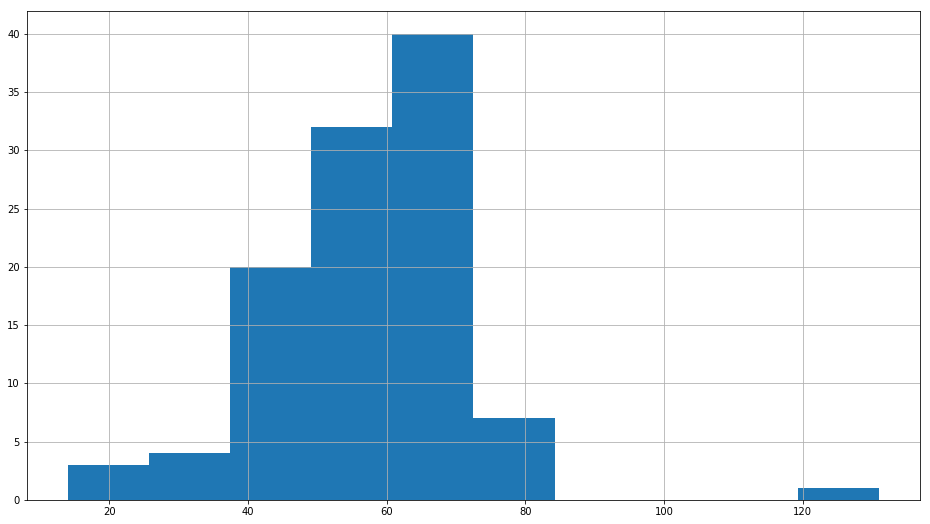

In [12]:
s4_only.TripID.value_counts().hist(figsize=(16, 9))

### Pick one that's on the far right

In [13]:
vcs = s4_only.TripID.value_counts()
s4_only[s4_only.TripID.isin(vcs[vcs > 115].index)].TripID.unique()

array(['944128020'], dtype=object)

In [14]:
pd.options.display.max_rows = 200
INTERESTING_TRIP = '944128020'
interesting_id = s4_only[s4_only.TripID == INTERESTING_TRIP].sort_values('dt')
interesting_id

I am densified (131 elements)
I am densified (131 elements)


,BlockNumber,DateTime,Deviation,DirectionNum,DirectionText,Lat,Lon,RouteID,TripEndTime,TripHeadsign,TripID,TripStartTime,VehicleID,geometry,dt
372456,MS-51,2019-04-01T05:15:33,-4.0,1,SOUTH,38.993366,-77.030190,S4,2019-04-01T05:52:00,FRANKLIN SQUARE,944128020,2019-04-01T05:18:00,8041,POINT (-8574961.526509114 4720721.353546063),2019-04-01 05:15:33
21629,MS-51,2019-04-01T05:16:34,-4.0,1,SOUTH,38.993366,-77.030190,S4,2019-04-01T05:52:00,FRANKLIN SQUARE,944128020,2019-04-01T05:18:00,8041,POINT (-8574961.526509114 4720721.353546063),2019-04-01 05:16:34
156893,MS-51,2019-04-01T05:17:35,-4.0,1,SOUTH,38.993366,-77.030190,S4,2019-04-01T05:52:00,FRANKLIN SQUARE,944128020,2019-04-01T05:18:00,8041,POINT (-8574961.526509114 4720721.353546063),2019-04-01 05:17:35
95533,MS-51,2019-04-01T05:18:34,-4.0,1,SOUTH,38.993320,-77.030067,S4,2019-04-01T05:52:00,FRANKLIN SQUARE,944128020,2019-04-01T05:18:00,8041,POINT (-8574947.834211746 4720714.765060599),2019-04-01 05:18:34
121605,MS-51,2019-04-01T05:19:36,-4.0,1,SOUTH,38.993992,-77.030609,S4,2019-04-01T05:52:00,FRANKLIN SQUARE,944128020,2019-04-01T05:18:00,8041,POINT (-8575008.169375755 4720811.014665237),2019-04-01 05:19:36
194548,MS-51,2019-04-01T05:20:37,-4.0,1,SOUTH,38.993992,-77.030609,S4,2019-04-01T05:52:00,FRANKLIN SQUARE,944128020,2019-04-01T05:18:00,8041,POINT (-8575008.169375755 4720811.014665237),2019-04-01 05:20:37
420557,MS-51,2019-04-01T05:21:44,2.0,1,SOUTH,38.993324,-77.033073,S4,2019-04-01T05:52:00,FRANKLIN SQUARE,944128020,2019-04-01T05:18:00,8041,POINT (-8575282.460601071 4720715.337972211),2019-04-01 05:21:44
580413,MS-51,2019-04-01T05:22:25,2.0,1,SOUTH,38.992527,-77.035774,S4,2019-04-01T05:52:00,FRANKLIN SQUARE,944128020,2019-04-01T05:18:00,8041,POINT (-8575583.134545702 4720601.185973562),2019-04-01 05:22:25
446184,MS-51,2019-04-01T05:23:41,1.0,1,SOUTH,38.987411,-77.036377,S4,2019-04-01T05:52:00,FRANKLIN SQUARE,944128020,2019-04-01T05:18:00,8041,POINT (-8575650.260198653 4719868.466738001),2019-04-01 05:23:41
635599,MS-51,2019-04-01T05:24:52,1.0,1,SOUTH,38.979675,-77.036407,S4,2019-04-01T05:52:00,FRANKLIN SQUARE,944128020,2019-04-01T05:18:00,8041,POINT (-8575653.599783376 4718760.608748325),2019-04-01 05:24:52


### Hmm
looks like this is 2 separate trips, given the hour break between reporting from 9:06 to 10:07

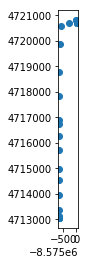

In [15]:
from datetime import datetime
cut_time =  datetime(2019, 4, 1, 12, 0)

color = [('red' if x <= cut_time else 'blue') for x in interesting_id['dt']]

interesting_id[interesting_id.dt < cut_time].plot()

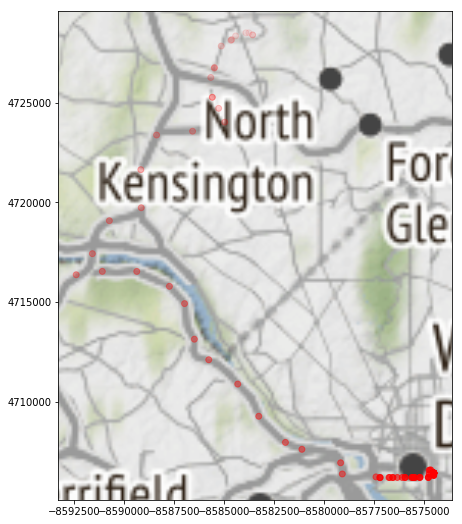

In [17]:
import numpy as np
alphas = (interesting_id[interesting_id.dt > cut_time].dt -\
          interesting_id[interesting_id.dt > cut_time].dt.min()).dt.total_seconds()
alphas = alphas / alphas.max()
rgba_colors = np.zeros((len(alphas),4))
rgba_colors[:, 0] = 1
rgba_colors[:, 3] = alphas
ax = interesting_id[interesting_id.dt > cut_time].plot(color=rgba_colors, figsize=(16, 9))
#interesting_id[interesting_id.dt < cut_time].plot(alpha=.2, color='blue', ax=ax)
add_basemap(ax, zoom=10)


In [19]:
(interesting_id.dt < cut_time).sum(), (~(interesting_id.dt < cut_time)).sum()

(49, 82)

In [21]:
gtfs_trips = pd.read_csv("data/gtfs/trips.txt", dtype={'trip_id': str, 'scheduled_trip_id': str})
gtfs_schedule = pd.read_csv("data/gtfs/stop_times.txt", dtype={'trip_id': str})
gtfs_cal = pd.read_csv("data/gtfs/calendar_dates.txt")
gtfs_trips[gtfs_trips['scheduled_trip_id'] == INTERESTING_TRIP]

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,scheduled_trip_id


In [35]:
gtfs_trips[gtfs_trips['scheduled_trip_id'] == INTERESTING_TRIP]

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,scheduled_trip_id


In [58]:
unique_trips = set(s4_only.TripID.unique())
unique_in_gtfs = set(gtfs_trips['scheduled_trip_id'])
len(unique_trips), len(unique_trips - unique_in_gtfs), len(unique_trips)- len(unique_trips - unique_in_gtfs)

(107, 15, 92)

In [46]:
diff = unique_trips - unique_in_gtfs

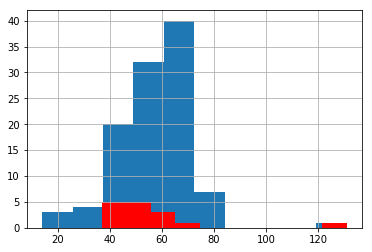

In [49]:
s4_only.TripID.value_counts().hist()
s4_only[s4_only.TripID.isin(diff)].TripID.value_counts().hist(color='red')

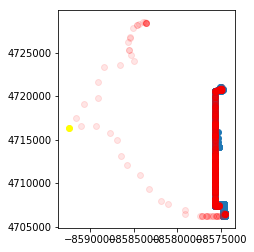

In [73]:
ax = s4_only[~s4_only.TripID.isin(diff)].plot()
ax = s4_only[s4_only.TripID.isin(diff)].plot(color='red', alpha=.1, ax=ax)
MIN = s4_only.geometry.x.min()
s4_only[s4_only.geometry.x == MIN].plot(ax=ax, color='yellow')

In [82]:
service_ids_today = gtfs_cal[gtfs_cal.date == 20190401].service_id.unique()
all_s4_trips = gtfs_trips[gtfs_trips.route_id == "S4"]
all_s4_trips_today = all_s4_trips[all_s4_trips.service_id.isin(service_ids_today)]
len(all_s4_trips), len(all_s4_trips_today)

(622, 111)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [70]:
gtfs_trips.service_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

### Generalize the above

In [104]:
trips_today = gtfs_trips[gtfs_trips.service_id.isin(service_ids_today)]
route_ids = trips_today.route_id.unique()

def pct_present(route_today):
    route_id = route_today.RouteID.iloc[0]
    unique_trips_today = set(route_today.TripID.unique())
    unique_trips_scheduled = set(trips_today[trips_today.route_id == route_id].scheduled_trip_id.unique())
    scheduled_and_reported = unique_trips_today.intersection(unique_trips_scheduled)
    return pd.Series((len(unique_trips_today), len(unique_trips_scheduled),
          len(scheduled_and_reported) / (len(unique_trips_scheduled) if len(unique_trips_scheduled) > 0 else 999999)* 100))
pct_present_report = df.groupby("RouteID").apply(pct_present)
pct_present_report.columns = ["n_reported_today", "n_in_schedule", "pct_present"]

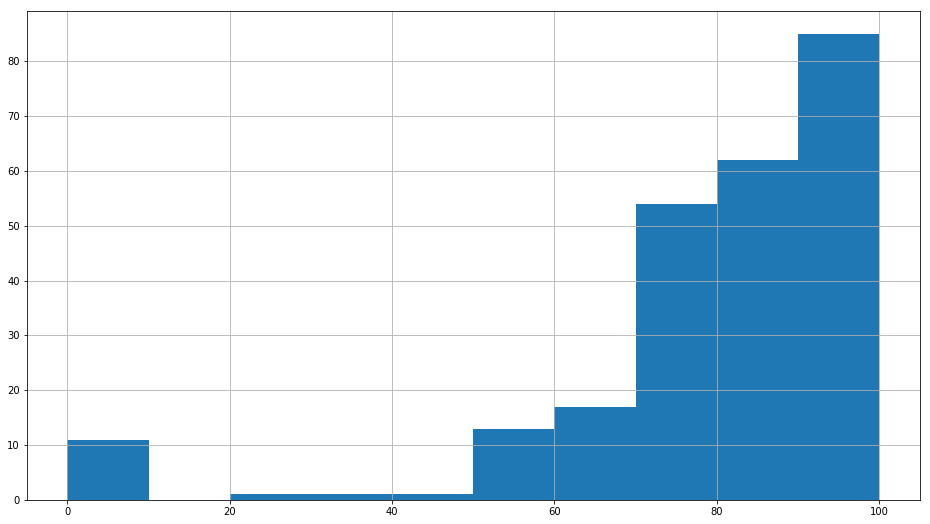

In [106]:
pct_present_report.pct_present.hist(figsize=(16, 9))

In [108]:
pct_present_report["bayes"] = (pct_present_report["pct_present"] * pct_present_report["n_in_schedule"] + 7) /\
                              (pct_present_report["n_in_schedule"] + 10)

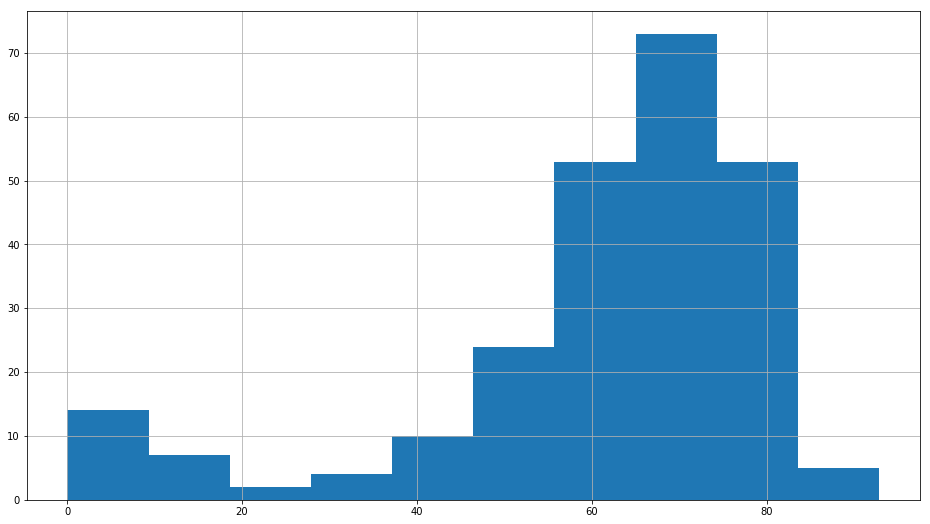

In [109]:
pct_present_report.bayes.hist(figsize=(16, 9))

In [105]:
pd.options.display.max_rows = 250
pct_present_report.sort_values("pct_present")


,n_reported_today,n_in_schedule,pct_present
RouteID,,,
MW1,225.0,0.0,0.000000
F99,79.0,0.0,0.000000
C29,2.0,0.0,0.000000
N6,9.0,19.0,0.000000
23A,7.0,8.0,0.000000
S80,113.0,159.0,0.000000
SH99,40.0,0.0,0.000000
16E,6.0,8.0,0.000000
B99,148.0,0.0,0.000000
